# Kardio: Using KNN to Advance Predictive Analytics for Heart Disease Diagnosis

**Group:** 3

**Members:** Maggie Cui, Tristan Heilbron, David Li, Ivy Nguyen

## Introduction

Heart disease is currently the leading cause of death globally and the second leading in Canada (Statistics Canada, 2023; World Health Organization, 2020). It is associated with plaque buildup in arteries, which could result in heart attack, heart failure, or death. Various factors impact the likely-hood of heart disease (age, cholesterol, and blood pressure), and understanding the influence of these factors is crucial for early detection and intervention, which can significantly improve patient outcomes and reduce healthcare costs. Thus, in better determining its primary contributing factors and improving diagnosis, we pose the question: "**What measurable factors most strongly impact the occurrence of heart disease, and based on these factors, will a new patient have heart disease?**"

We will utilize the **Heart Disease** database compiled by Detrano et al. (1988) which contains four datasets with 76 variables. We will only use the processed datasets collected by the Cleveland Clinic Foundation and Hungarian Institute of Cardiology, which contain 14 relevant variables. These datasets were selected due to their large number of observations to improve accuracy and to represent a wider population.

## Methods & Results

After loading the datasets, we will tidy and wrangle our data by converting variables to their correct data types, combining the two datasets, converting the label variable to be human readable, extracting relevant variables, and splitting it into a 75% training set and 25% testing set.

We will generate summary tables for the number and percentage of observations for each diagnosis class, the number of missing values, and the mean of predictor variables. We will create a density plot to visualize the distribution of predictor variables and scatter plots to show potential patterns or groupings between predictor variables.

Our classification model is trained using the K-nearest neighbors algorithm. As such, we must standardize the training data through centering, scaling, and mean imputing missing values. We will perform forward selection to determine the most relevant feature variables and tune the K parameter on a range of 1 to 100 with a 5-fold cross-validation.  

To evaluate the performance and practicality of our KNN model, we will generate the confusion matrix and calculate its accuracy, precision, and recall based on predictions made on the testing set.

Our feature variables are
1. **Age (`age`):** As age increases, more plaque accumulates and arteries stiffen, restricting blood flow and amplifying the effects of plaque buildup (Stern et al., 2003).
2. **Resting blood pressure (`trestbps`):** High blood pressure damages arteries and excessively strains the heart (Tackling & Borhade, 2019).
3. **Serum cholesterol (`chol`):** High levels of cholesterol in the bloodstream results in plaque buildup (Jung et al., 2022).
4. **Maximum heart rate (`thalach`):** Low maximum heart rate is indicative of low aerobic capacity, potentially a result of excessive strain or damage to the heart (Harvard Health Publishing, 2020).
5. **Exercise induced ST depression (`oldpeak`):** ST depression in the electrocardiogram could indicate a reduction in blood flow to the heart from plaque buildup (Kashou & Kashou, 2019).

Our label variable is `num` (renamed to `diagnosis`). As the authors never indicated what a value of 2, 3, or 4 meant, we will assume it indicates the presence (1, 2, 3, 4) or absence (0) of heart disease.

### Data processing

#### Loading required libraries

We will first load all the necessary R packages for wrangling data, creating visualization, and training KNN models. To ensure our analysis is random but reproducible, the random seed is set to the predetermined value of `2005`.

In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(repr)
library(RColorBrewer)

# Set a seed so our analysis is random but reproducible
set.seed(2005)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

#### Loading the dataset

As the original source of the database doesn't provide access to individual datasets, we have manually downloaded the database and re-uploaded the necessary datasets (Cleveland and Hungarian) to our public GitHub repository so that we can load it through an URL. Additionally, since the datasets don't contain column names, we will manually add them during loading.

In [2]:
cleveland_data_url <- "https://raw.githubusercontent.com/MYYaaa/datascience_project_group3/main/data/processed.cleveland.data"
hungarian_data_url <- "https://raw.githubusercontent.com/MYYaaa/datascience_project_group3/main/data/processed.hungarian.data"

data_column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

cleveland_data <- read_csv(cleveland_data_url, col_names = data_column_names)
hungarian_data <- read_csv(hungarian_data_url, col_names = data_column_names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Cleaning and wrangling the data

Looking at the dataset information returned, we can see some columns are of the wrong data type. The `trestbps` (resting blood pressure) column of the Hungarian dataset is supposed to contain numeric data but instead contain character data. We will filter it for all values that can't be converted into a number.

In [3]:
# Look through all (distinct) values within trestbps and try to convert it to the number,
# we use suppressWarnings since we know that it is a coercion into NA
unknown_chr_value <- hungarian_data |>
    select(trestbps) |>
    distinct() |>
    filter(suppressWarnings(is.na(as.numeric(trestbps))))

print("Table 1. Character values within the trestbps column of the Hungarian dataset.")
unknown_chr_value

[1] "Table 1. Character values within the trestbps column of the Hungarian dataset."


trestbps
<chr>
?


From `Table 1`, we can see that the character is a `?`, which we can confidently assume represents a missing value. Additionally, the dataset authors noted that `-9.0` meant a missing value. Thus, we will replace all `?` and `-9.0` values by `NA` to represent the missing data in a way that R can understand.

In [4]:
# Substituting all "?" and "-9.0" with NA
# REFERENCE: https://stackoverflow.com/a/19503330
cleveland_data[cleveland_data == "?"] <- NA
hungarian_data[hungarian_data == "?"] <- NA

cleveland_data[cleveland_data == "-9.0"] <- NA
hungarian_data[hungarian_data == "-9.0"] <- NA

We will convert each column to their correct data type.

In [5]:
# Converting to correct data types
numeric_column_names <- c("age", "trestbps", "chol", "thalach", "oldpeak", "ca")
factor_column_names <- c("sex", "cp", "fbs", "restecg", "exang", "slope", "thal", "num")

cleveland_data <- cleveland_data |>
    mutate(across(all_of(numeric_column_names), as.numeric)) |>
    mutate(across(all_of(factor_column_names), as_factor))

hungarian_data <- hungarian_data |>
    mutate(across(all_of(numeric_column_names), as.numeric)) |>
    mutate(across(all_of(factor_column_names), as_factor))

Now, we combine the Cleveland and Hungarian datasets.

In [6]:
# Combining the two data sets
heart_disease_data <- bind_rows(cleveland_data, hungarian_data)

To make our data human readable, we will change the name of our label to `diagnosis` and recode the number factors into `absent` and `present`.

In [7]:
# Make the label variable more readable
heart_disease_data <- heart_disease_data |>
    mutate(diagnosis = fct_recode(num, "absent" = "0", "present" = "1", "present" = "2", "present" = "3", "present" = "4")) |>
    # Move the label to be the first column
    relocate(diagnosis) |>
    select(-num)

To ensure that the wrangling steps are done properly, we will display a short segment of the dataset.

In [8]:
# Display the tidied data set with all variables
print("Table 2. Tidied data for the combined Cleveland and Hungarian heart disease datasets.")
glimpse(heart_disease_data)

[1] "Table 2. Tidied data for the combined Cleveland and Hungarian heart disease datasets."
Rows: 597
Columns: 14
$ diagnosis <fct> absent, present, present, absent, absent, absent, present, a…
$ age       <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44, 52, …
$ sex       <fct> 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, …
$ cp        <fct> 1, 4, 4, 3, 2, 2, 4, 4, 4, 4, 4, 2, 3, 2, 3, 3, 2, 4, 3, 2, …
$ trestbps  <dbl> 145, 160, 120, 130, 130, 120, 140, 120, 130, 140, 140, 140, …
$ chol      <dbl> 233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, …
$ fbs       <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, …
$ restecg   <fct> 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, …
$ thalach   <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, 153, …
$ exang     <fct> 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ oldpeak   <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0.4, 1.3, …
$ slop

Irrelevant variables and variables that won't work well in a KNN analysis (like factors) will be removed, leaving only the predictors and label variable.

In [9]:
# Select only the variables we plan on using
variables_of_interest <- c("diagnosis", "age", "trestbps", "chol", "thalach", "oldpeak")

heart_disease_data <- select(heart_disease_data, all_of(variables_of_interest))

# Display the tidied data set with only the variables we are using
print("Table 3. Tidied data for the heart disease dataset containing only relevant variables.")
glimpse(heart_disease_data)

[1] "Table 3. Tidied data for the heart disease dataset containing only relevant variables."
Rows: 597
Columns: 6
$ diagnosis <fct> absent, present, present, absent, absent, absent, present, a…
$ age       <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44, 52, …
$ trestbps  <dbl> 145, 160, 120, 130, 130, 120, 140, 120, 130, 140, 140, 140, …
$ chol      <dbl> 233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, …
$ thalach   <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, 153, …
$ oldpeak   <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0.4, 1.3, …


#### Splitting the data

We will split the dataset into a $75\%$ training set and $25\%$ testing set. Having these two sets of data means that we can use one (training set) to train and tune our KNN model and the other (testing set) to properly evaluate how well our model is at predicting on new observations.

In [10]:
# Set a seed so our analysis is random but reproducible
set.seed(2005)

heart_disease_data_split <- heart_disease_data |>
    initial_split(prop = 0.75, strata = diagnosis)

heart_disease_training <- training(heart_disease_data_split)
heart_disease_testing <- testing(heart_disease_data_split)

### Exploratory data analysis

#### Summary of training data

In [11]:
# Display the number of observations for each diagnoses
total_observation_count <- nrow(heart_disease_training)

observation_count_summary <- heart_disease_training |>
    group_by(diagnosis) |>
    summarize(number_of_observations = n(),
              percentage = (n() / total_observation_count) * 100)

print("Table 4. Summary of the proportion and number of observations for each heart disease diagnosis.")
observation_count_summary

[1] "Table 4. Summary of the proportion and number of observations for each heart disease diagnosis."


diagnosis,number_of_observations,percentage
<fct>,<int>,<dbl>
absent,264,59.0604
present,183,40.9396


From `Table 4`, we can see that more observations are labelled as `absent` than `present`, a difference of around $19\%$, or $81$ observations. We believe that having this minor class imbalance shouldn't affect our model performance and doesn't justify having to deal with nuances and problems that could arise when oversampling the data.

In [12]:
# Display number of rows with missing data
missing_data_summary <- heart_disease_training |>
    group_by(diagnosis) |>
    filter(if_any(everything(), is.na)) |>
    summarize(number_of_rows_with_missing_values = n())

print("Table 5. Summary of the number of rows with missing values.")
missing_data_summary

[1] "Table 5. Summary of the number of rows with missing values."


diagnosis,number_of_rows_with_missing_values
<fct>,<int>
absent,16
present,2


Although there aren't many missing values within our training set (as seen in `Table 5`), to ensure our model isn't overlooking potential patterns within the dataset, we will perform mean imputation rather than removing the observations with missing values.

In [13]:
# Display the average value of predictor variables
average_value_summary <- heart_disease_training |>
    # Add a suffix to the column names except for diagnosis
    # REFERENCE: https://dplyr.tidyverse.org/reference/rename.html
    rename_with(~ paste(.x, "average", sep = "_"), -diagnosis) |>
    group_by(diagnosis) |>
    summarize(across(everything(), ~ mean(.x, na.rm = TRUE)))

print("Table 6. Summary of the average values for each variable within each heart disease diagnosis.")
average_value_summary

[1] "Table 6. Summary of the average values for each variable within each heart disease diagnosis."


diagnosis,age_average,trestbps_average,chol_average,thalach_average,oldpeak_average
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
absent,50.06061,130.5095,243.2570,149.4981,0.4117424
present,53.72678,135.8743,260.5801,134.3607,1.3595628


In `Table 6`, we can see that there is a clear difference in the mean predictor values between the two `diagnosis` classes. This suggests that these predictors are usable by our model to differentiate between the two diagnoses. Individuals with heart disease tends to have a higher value for `age`, `trestbps`, `chol`, and `oldpeak` while a lower value for `thalach`.

#### Visualization of training data

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”
Warning message:
“Removed 17 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”


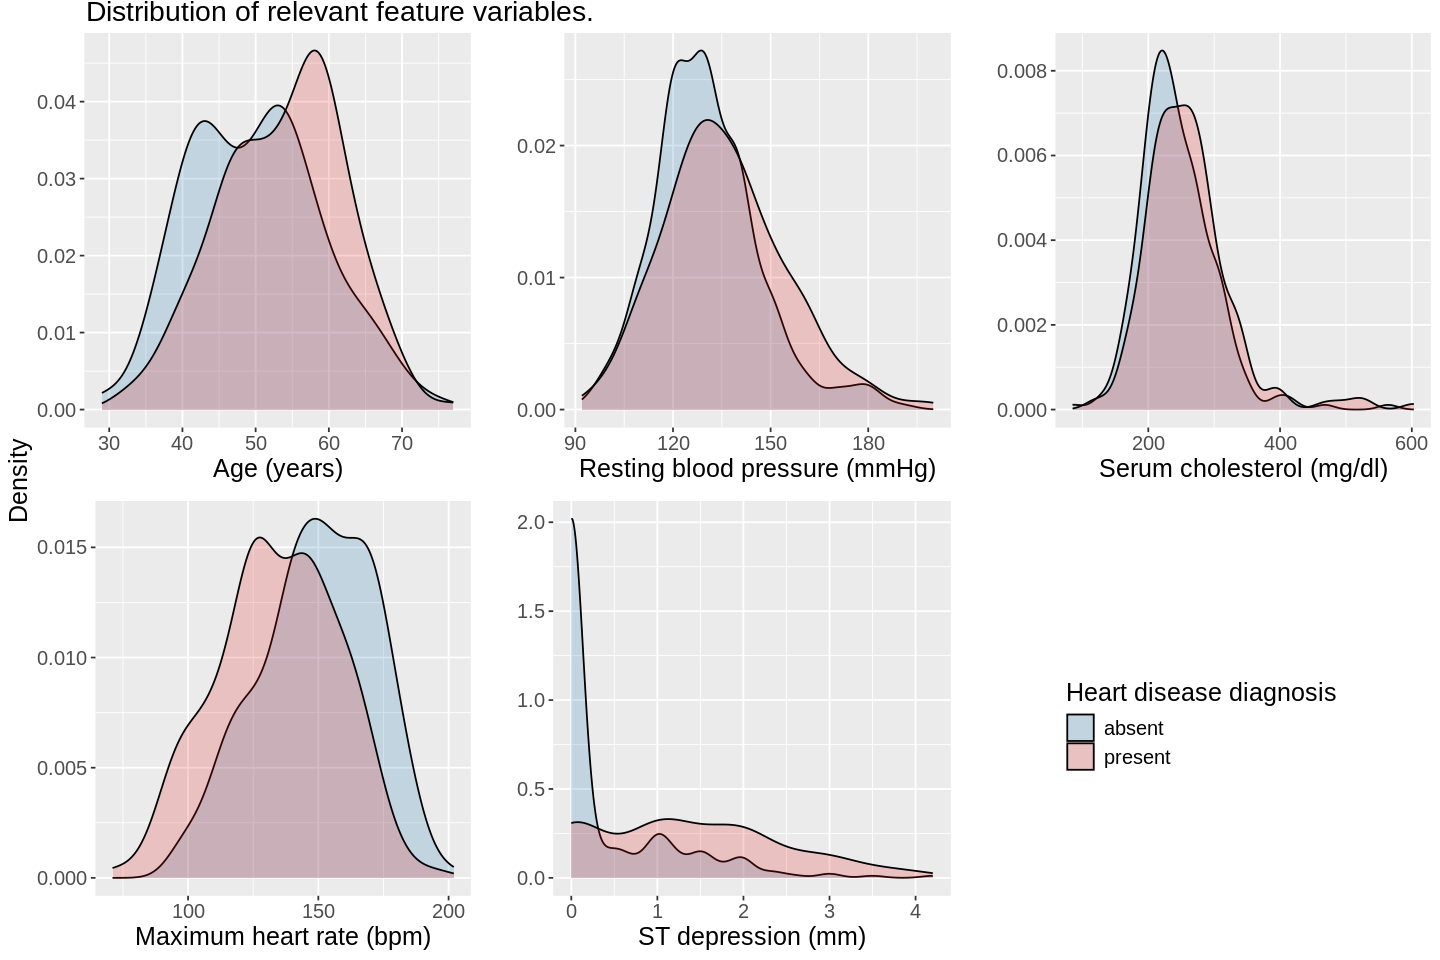

In [14]:
# Visualize the distribution of our relevant feature variables
options(repr.plot.width = 12, repr.plot.height = 8)

# Create a distribution plot for all feature variables
# with some colour blind friendly fill colours
age_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = age, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "Age (years)", y = "",
             fill = "Heart disease diagnosis") +
        theme(text = element_text(size = 15),
              legend.direction = "vertical") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

trestbps_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = trestbps, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "Resting blood pressure (mmHg)", y = "") +
        theme(text = element_text(size = 15),
              legend.position = "none") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

chol_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = chol, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "Serum cholesterol (mg/dl)", y = "") +
        theme(text = element_text(size = 15),
              legend.position = "none") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

thalach_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = thalach, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "Maximum heart rate (bpm)", y = "") +
        theme(text = element_text(size = 15),
              legend.position = "none") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

oldpeak_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = oldpeak, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "ST depression (mm)", y = "") +
        theme(text = element_text(size = 15),
              legend.position = "none") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

# REFERENCES:
# https://wilkelab.org/cowplot/articles/plot_grid.html
# https://wilkelab.org/cowplot/articles/shared_legends.html

# Extract the legend from the age plot,
distribution_plots_legend <- suppressWarnings(get_legend(age_distribution_plot))

# Plot all the distribution plots and the shared legend
distribution_plots <- plot_grid(age_distribution_plot + theme(legend.position = "none"),
                                trestbps_distribution_plot,
                                chol_distribution_plot,
                                thalach_distribution_plot,
                                oldpeak_distribution_plot,
                                distribution_plots_legend)

# Create a plot title
distribution_plots_title <- ggdraw() +
    draw_label("Distribution of relevant feature variables.",
               x = 0.06,
               hjust = 0,
               size = 17)

# Add the plot title and y axis label
distribution_plots <- plot_grid(distribution_plots_title,
                                distribution_plots,
                                ncol = 1,
                                rel_heights = c(0.025, 1)) +
    draw_label("Density", x = 0, y = 0.5, vjust = 1.5, angle = 90, size = 15)

distribution_plots

**Figure 1. Density distribution plot of relevant feature variables.**

From `Figure 1`, we see that values for ST depression (`oldpeak`), maximum heart rate (`thalach`), and age (`age`) have a separation between the two diagnosis classes. Thus, we predict that they are likely to be the strongest predictor variables for the KNN model. In the later analysis, we will perform forward selection to see if we can quantitatively confirm this observation.

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


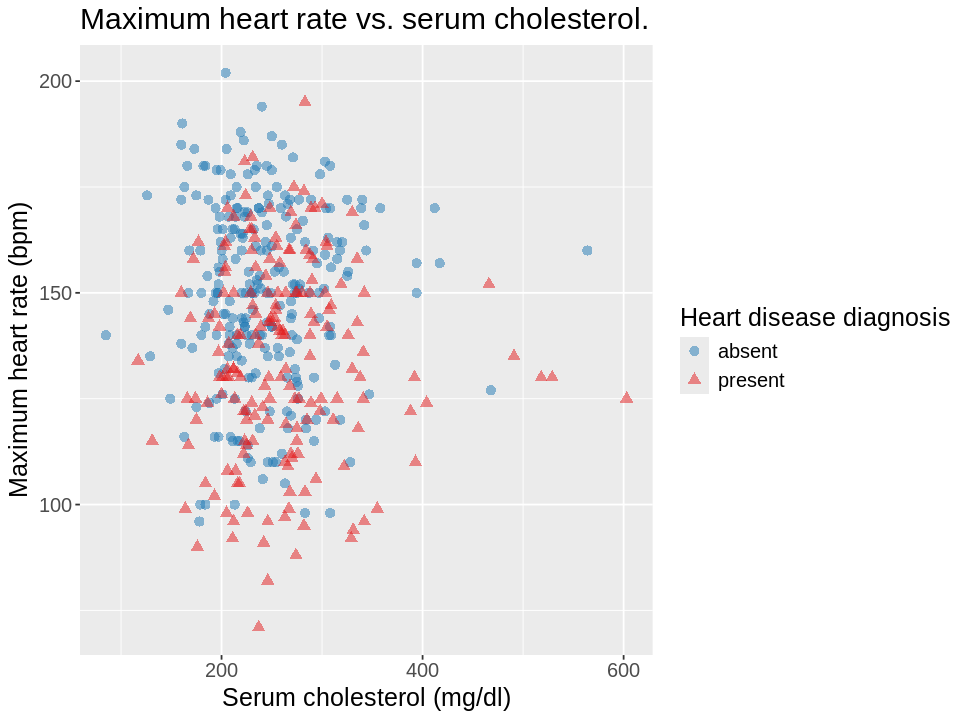

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)

thalach_vs_chol_plot <- heart_disease_training |>
    ggplot(aes(x = chol, y = thalach, colour = diagnosis, shape = diagnosis)) +
        geom_point(alpha = 0.5, size = 2.5) +
        labs(x = "Serum cholesterol (mg/dl)",
             y = "Maximum heart rate (bpm)",
             colour = "Heart disease diagnosis",
             shape = "Heart disease diagnosis",
             title = "Maximum heart rate vs. serum cholesterol.") +
        # Use some color blind friendly colors
        scale_color_manual(values = c("#1F78B4", "#E31A1C")) +
        theme(text = element_text(size = 15))

thalach_vs_chol_plot

**Figure 2. Scatter plot of maximum heart rate vs. serum cholesterol.**

We can see in `Figure 2` that patients with heart disease will tend to have a higher amount of serum cholesterol and a lower maximum heart rate.

Warning message:
“Removed 17 rows containing missing values or values outside the scale range
(`geom_point()`).”


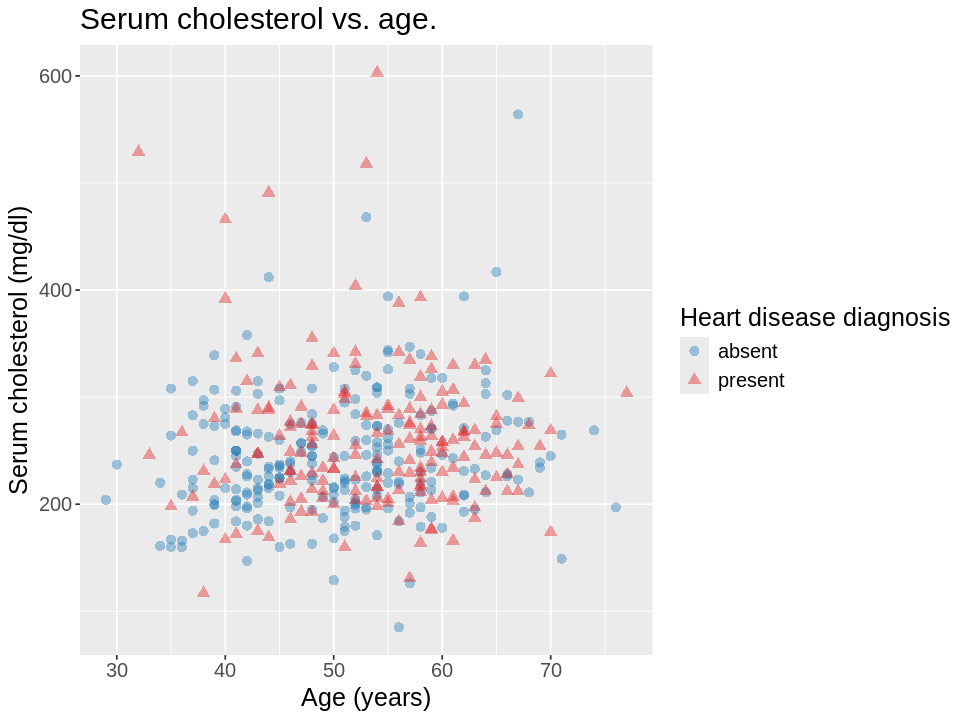

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)

chol_vs_age <- heart_disease_training |>
    ggplot(aes(x = age, y = chol, colour = diagnosis, shape = diagnosis)) +
        geom_point(alpha = 0.4, size = 2.5) +
        labs(x = "Age (years)",
             y = "Serum cholesterol (mg/dl)",
             colour = "Heart disease diagnosis",
             shape = "Heart disease diagnosis",
             title = "Serum cholesterol vs. age.") +
        # Use some color blind friendly colors
        scale_color_manual(values = c("#1F78B4", "#E31A1C")) +
        theme(text = element_text(size = 15))

chol_vs_age

**Figure 3. Scatter plot of serum cholesterol vs. age.**

As shown in `Figure 3`, patients with heart disease will tend to be older and have a higher level of serum cholesterol.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


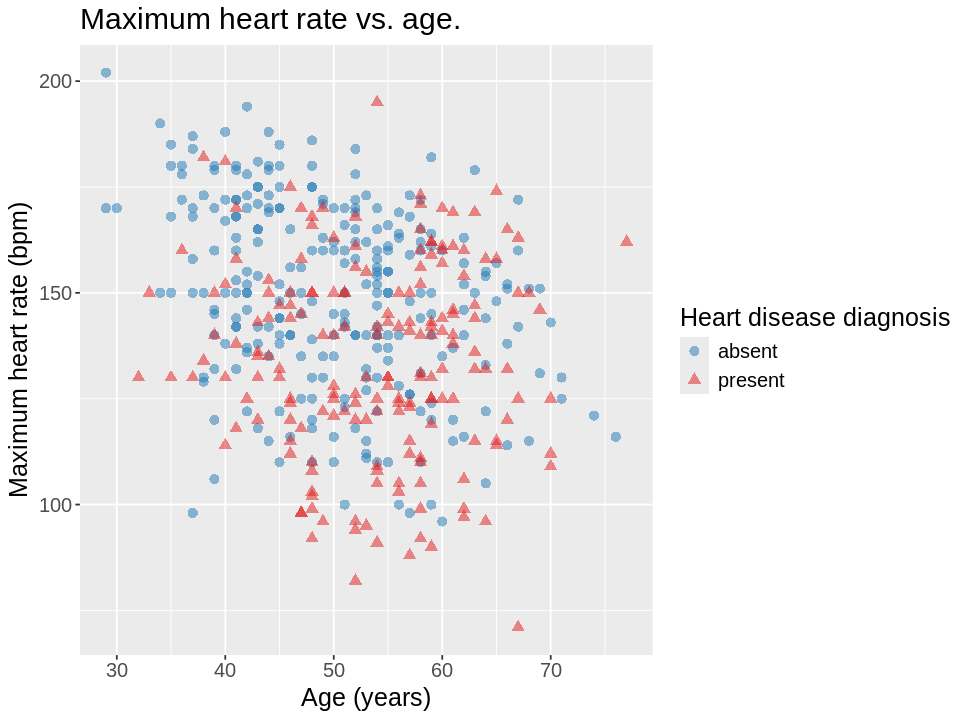

In [17]:
options(repr.plot.width = 8, repr.plot.height = 6)

thalach_vs_age <- heart_disease_training |>
    ggplot(aes(x = age, y = thalach, colour = diagnosis, shape = diagnosis)) +
        geom_point(alpha = 0.5, size = 2.5) +
        labs(x = "Age (years)",
             y = "Maximum heart rate (bpm)",
             colour = "Heart disease diagnosis",
             shape = "Heart disease diagnosis",
             title = "Maximum heart rate vs. age.") +
        # Use some color blind friendly colors
        scale_color_manual(values = c("#1F78B4", "#E31A1C")) +
        theme(text = element_text(size = 15))

thalach_vs_age

**Figure 4. Scatter plot of maximum heart rate vs. age.**

In `Figure 4`, we see that older ages and lower maximum heart rate corresponds to a higher likelyhood of having heart disease.

From the three scatter plots, we see significant overlap between data points for the two diagnoses. As such, we expect that our model may have difficulties in distinguishing between the two diagnoses. Consequently, our choice of K parameter is crucial to ensure that we have a large enough number of neighbors for the model to distinguish between the highly overlapping groups while avoiding underfitting.

There is also clear differences in the scale and spread of data for each predictor which indicates the need for standardization to ensure our KNN model results aren't biased towards a particular predictor.

### Model training and tuning

To answer our predictive question, we will utilize a KNN model with a `rectangular` weight function (equal weighting between data points), the `kknn` engine, and specify that we are performing a `classification` problem.

#### Forward selection of predictor variables

While KNN can accept any number of predictors, having more doesn't always result in better predictions. We must then extract the predictors which are most relevant in diagnosing heart disease and will result in the best performing model.

One approach is manual selection, as we did during exploratory data analysis. While this is simple and fast, it is error-prone and doesn't always result in the best predictors. Another approach is a best subset selection, which involves testing every combination of predictors. Although it will select the best predictors, it is slow and computationally expensive; for our analysis, it would require evaluating $2^5-1=32$ different models.

Instead, we will use the forward selection algorithm, which gives a good approximation for the best predictors and only require testing $\frac{1}{2}5(5+1)=15$ models.

This process involves:
1. Adding each unused predictor to the model to create a candidate.
2. Tuning the candidates with 5-fold cross-validation.
3. Updating the model to be the best performing candidate.
4. Repeating steps `2` to `5` until all predictors are used.

In [18]:
# This enables us to skip forward selection since the process takes quite a while (~2 minutes)
perform_forward_selection = TRUE

In [19]:
# Set a seed so our analysis is random but reproducible
set.seed(2005)

# Perform forward selection only if we want to
if (perform_forward_selection) {
    
    # names of predictor variables we will use
    predictor_names <- heart_disease_training |>
        select(-diagnosis) |>
        colnames()
    
    # tibble for storing results of each selection
    fs_accuracies <- tibble(size = integer(),
                            model_string = character(),
                            accuracy = numeric())
    
    # create the tuning model specification
    fs_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")
    
    # use a 5-fold cross-validation
    fs_vfold <- vfold_cv(heart_disease_training, v = 5, strata = diagnosis)
    
    # k-values for which the models will be tuned with
    fs_k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))
    
    predictor_count <- length(predictor_names)
    selected_predictors <- c()
    
    for (i in 1:predictor_count) {
        # for every predictor still not added yet
        accs <- list()
        models <- list()
        for (j in 1:length(predictor_names)) {
            # create a model string for this combination of predictors
            preds_new <- c(selected_predictors, predictor_names[[j]])
            model_string <- paste("diagnosis", "~", paste(preds_new, collapse=" + "))
    
            # create a recipe from the model string
            fs_recipe <- recipe(as.formula(model_string), data = heart_disease_training) |>
                step_scale(all_predictors()) |>
                step_impute_mean(all_predictors()) |>
                step_center(all_predictors())

            # tune the K-NN classifier with these predictors,
            # and collect the accuracy for the best K
            acc <- workflow() |>
                add_recipe(fs_recipe) |>
                add_model(fs_knn_spec) |>
                tune_grid(resamples = fs_vfold, grid = fs_k_vals) |>
                collect_metrics() |>
                filter(.metric == "accuracy") |>
                summarize(mx = max(mean))
            acc <- acc$mx |> unlist()
    
            # add this result to the dataframe
            accs[[j]] <- acc
            models[[j]] <- model_string
        }
        jstar <- which.max(unlist(accs))
        fs_accuracies <- fs_accuracies |>
            add_row(size = i,
                    model_string = models[[jstar]],
                    accuracy = accs[[jstar]])
        selected_predictors <- c(selected_predictors, predictor_names[[jstar]])
        predictor_names <- predictor_names[-jstar]
    }
} else {
    print("Not performing forward selection!")
}

[1] "Table 7. Predictor variable combinations from forward selection arranged by descending accuracy."
# A tibble: 5 × 3
   size model_string                                          accuracy
  <int> <chr>                                                    <dbl>
1     2 diagnosis ~ oldpeak + thalach                            0.758
2     5 diagnosis ~ oldpeak + thalach + age + trestbps + chol    0.750
3     4 diagnosis ~ oldpeak + thalach + age + trestbps           0.749
4     3 diagnosis ~ oldpeak + thalach + age                      0.749
5     1 diagnosis ~ oldpeak                                      0.738


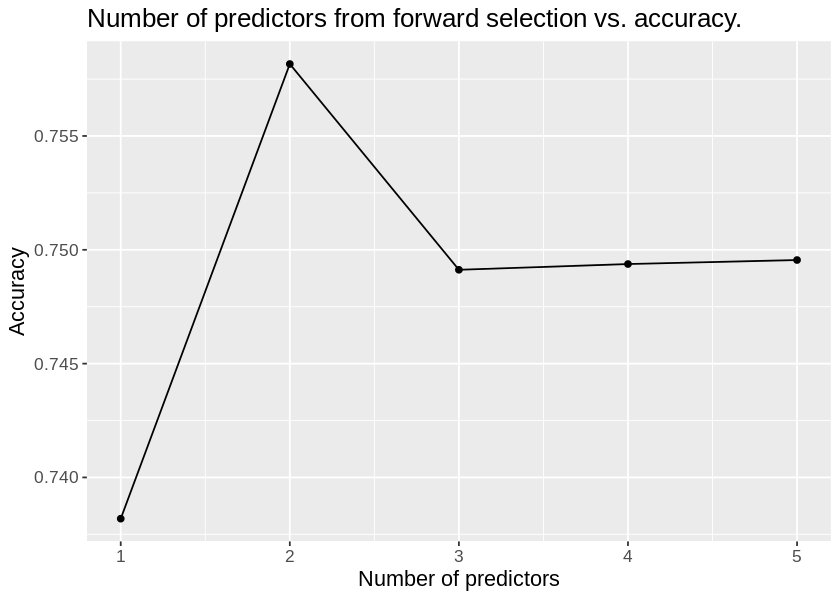

In [20]:
# Display the results of forward selection if we have performed it
if (perform_forward_selection) {

    # Arrange the predictor formulas by highest accuracy first
    predictors_by_accuracy <- fs_accuracies |>
        arrange(-accuracy)

    print("Table 7. Predictor variable combinations from forward selection arranged by descending accuracy.")
    print(predictors_by_accuracy)

    options(repr.plot.width = 7, repr.plot.height = 5)
    
    predictor_accuracy_plot <- fs_accuracies |>
        ggplot(aes(x = size, y = accuracy)) +
            geom_point() +
            geom_line() +
            labs(x = "Number of predictors",
                 y = "Accuracy",
                 title = "Number of predictors from forward selection vs. accuracy.") +
            theme(text = element_text(size = 13))
    predictor_accuracy_plot
} else {
    print("Not performing forward selection!")
}

**Figure 5. Number of predictors used vs. estimated accuracy for a KNN model.**

From `Table 7` and `Figure 5`, we know that the most relevant predictors are `oldpeak + thalach` (ST depression and maximum heart rate) with a model accuracy estimate of $75.8\%$. We are confident in this result as they match the predictions we made during exploratory data analysis, where we concluded that `oldpeak`, `thalach`, and `age` are likely to be the most relevant predictors.

#### Tuning the model K parameter

Knowing the best predictors to use for our model, we will now tune the K parameter (number of neighbors) of the KNN model from a range of $1$ to $100$ with a 5-fold cross-validation.

[1] "Table 8. First 6 rows of K parameters arranged by accuracy of the KNN model."


neighbors,mean
<dbl>,<dbl>
14,0.7520003
55,0.7517234
56,0.7517234
13,0.7497531
43,0.7472790
44,0.7472790


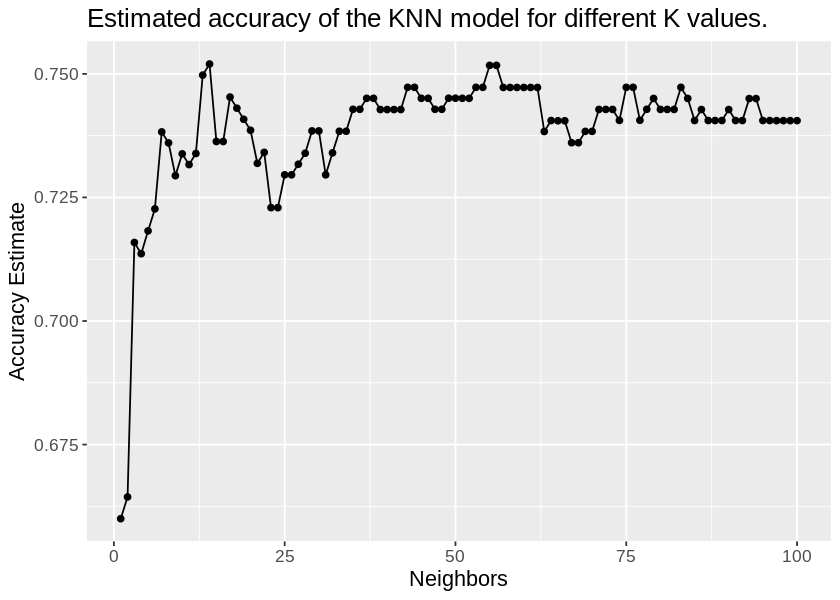

In [21]:
# Set a seed so our analysis is random but reproducible
set.seed(2005)

tune_recipe <- recipe(diagnosis ~ oldpeak + thalach, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_impute_mean(all_predictors()) |>
    step_center(all_predictors())

tune_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

tune_vfold <- vfold_cv(heart_disease_training, v = 5, strata = diagnosis)

tune_k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

tune_knn_results <- workflow() |>
    add_recipe(tune_recipe) |>
    add_model(tune_knn_spec) |>
    tune_grid(resamples = tune_vfold, grid = tune_k_vals) |>
    collect_metrics()

tune_accuracies <- tune_knn_results |>
    filter(.metric == "accuracy")

best_k_vals <- tune_accuracies |>
    select(neighbors, mean) |>
    slice_max(mean, n = 6)

print("Table 8. First 6 rows of K parameters arranged by accuracy of the KNN model.")
head(best_k_vals)

accuracy_vs_k_plot <- ggplot(tune_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors",
         y = "Accuracy Estimate",
         title = "Estimated accuracy of the KNN model for different K values.") +
    theme(text = element_text(size = 13))

accuracy_vs_k_plot

**Figure 6. Estimated accuracy from 5-fold cross-validation of a KNN model for different K values.**

Based on `Table 8` and the peaks in `Figure 6`, we see that the K parameter values of $14$, $55$, and $56$ all resulted in the highest cross-validation accuracy of $75.2\%$. However, given the relatively small size of our dataset, using too many neighbors will result in an underfit and negatively impact our model's ability to generalize to new data. As such, we will choose a K parameter of $14$.

#### Training the tuned KNN model

Using the tuning results, the final KNN classification model is created with `oldpeak + thalach` being the predictors, a neighbour count of $14$, and is fitted to our standardized training data.

In [22]:
heart_disease_recipe <- recipe(diagnosis ~ oldpeak + thalach, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_impute_mean(all_predictors()) |>
    step_center(all_predictors())

heart_disease_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_disease_fit <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(heart_disease_knn_spec) |>
    fit(data = heart_disease_training)

### Evaluating model performance

With our KNN classification model, we will make diagnosis predictions on the testing set to evaluate how well the model performs on new data (which is analogous to using our model on new patients).

In [23]:
# Make model predictions on the testing set
predictions <- predict(heart_disease_fit, heart_disease_testing) |>
    bind_cols(heart_disease_testing)

Aside from accuracy, there are two other metrics which are important: $\text{recall} = \frac{\text{\# of true positive predictions}}{\text{\# of positive observations}}$ and $\text{precision} = \frac{\text{\# of true positive predictions}}{\text{\# of positive predictions}}$. As our goal is to identify heart disease in patients, our positive label is `present` and negative label is `absent`. We will discuss the importance of these performance metrics in the context of our predictive question within the discussion section.

In [24]:
# Determine the factor level for each class
predictions |> pull(diagnosis) |> levels()

[1] "absent"  "present"

We can see that the two diagnosis classes are ordered such that `absent` is the first factor level and `present` is the second. Knowing this, we can now calculate all the metrics for our model with `present` (second factor level) being the positive class for recall and precision. A confusion matrix for our predictions will also be created.

In [25]:
# Calculate the performance metrics for the model
accuracy <- predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

precision <- predictions |>
    precision(truth = diagnosis, estimate = .pred_class, event_level="second")

recall <- predictions |>
    recall(truth = diagnosis, estimate = .pred_class, event_level="second")

metrics <- bind_rows(accuracy, precision, recall) |>
    select(.metric, .estimate) |>
    rename(metric = .metric, estimate_value = .estimate) |>
    mutate(estimate_value = estimate_value * 100)

print("Table 9. Accuracy, precision, and recall for the KNN classification model.")
metrics

confusion_matrix <- predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

print("Table 10. Confusion matrix for the KNN classification model.")
confusion_matrix

[1] "Table 9. Accuracy, precision, and recall for the KNN classification model."


metric,estimate_value
<chr>,<dbl>
accuracy,79.33333
precision,82.97872
recall,62.90323


[1] "Table 10. Confusion matrix for the KNN classification model."


          Truth
Prediction absent present
   absent      80      23
   present      8      39

## Discussion

From forward selection, we found that ST depression and maximum heart rate are most relevant to the occurrence of heart disease. Our KNN classification model has an accuracy of 79.33%, precision of 82.98%, and recall of 62.90%. This model performs significantly better than the majority classifier, which has an accuracy of 59.06%.

Looking at the confusion matrix, we see that our model performed well at identifying healthy patients. However, it often misdiagnosed patients with heart disease as being healthy, which is reflected in the low recall. Given the context of our question, achieving high recall is crucial as the consequences of overlooking a patient with heart disease is substantially worse than diagnosing a healthy patient as having heart disease.

We expected that age, maximum heart rate, and ST depression to have the most significant effect on the presence of heart disease. However, forward selection shows that only ST depression and maximum heart rate are the most significant factors. Furthermore, the model achieved an accuracy of 79.33%, meeting our expectations that it will perform significantly better than a majority classifier. On the other hand, we didn’t expect our model’s recall to be as low as 62.90%, which will significantly impact its practicality and usage.

Based on our results, the presence of heart disease can be better predicted in new patients, improving existing diagnosis and treatment models. Due to the relatively low recall, it can be used as an initial test to identify patients who have a high likelihood of heart disease so that fewer patients need to be thoroughly tested. However, it shouldn’t be used as a definite test for the absence of heart disease. Lastly, the model presents a non-invasive method of diagnosing heart disease as opposed to traditional methods like angiography (Tavakol et al., 2011).

It is important to note the limitation of this analysis, that heart disease exhibits randomness and complexity, influenced by various factors known to impact heart disease risk not captured in the dataset. This may limit the accuracy of our predictive models and introduce biases in our findings. Addressing these limitations requires comprehensive data collection strategies and integration of diverse datasets.

### Future questions

- How applicable is our model for patients today despite lifestyle changes and improvements in healthcare?
- Can the severity and type of heart disease be identified in a patient?
- How could we incorporate environmental factors experienced by a patient to improve our predictive accuracy?
- How effective is our approach compared to alternative predictive models or data analysis techniques at predicting heart disease within patients?

## References

<pre>
Detrano, R., Janosi, A., Steinbrunn, W., & Pfisterer, M. (1988). Heart Disease. In UCI Machine Learning Repository.
    https://doi.org/10.24432/C52P4X
    
Harvard Health Publishing. (2020, August 30). What your heart rate is telling you - Harvard Health. Harvard Health; Harvard Health.
    https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you
    
Jung, E., Kong, S. Y., Ro, Y. S., Ryu, H. H., & Shin, S. D. (2022). Serum Cholesterol Levels and Risk of Cardiovascular Death:
    A Systematic Review and a Dose-Response Meta-Analysis of Prospective Cohort Studies.
    International Journal of Environmental Research and Public Health, 19(14), 8272.
    https://doi.org/10.3390/ijerph19148272
    
Kashou, A. H., & Kashou, H. E. (2019). Rhythm, ST Segment. Nih.gov; StatPearls Publishing.
    https://www.ncbi.nlm.nih.gov/books/NBK459364/
    
Statistics Canada. (2023). Leading causes of death, total population, by age group.
    https://doi.org/10.25318/1310039401-eng
    
Stern, S., Behar, S., & Gottlieb, S. (2003). Aging and Diseases of the Heart. Circulation, 108(14).
    https://doi.org/10.1161/01.cir.0000086898.96021.b9
    
Tackling, G., & Borhade, M. B. (2019). Hypertensive Heart Disease. Nih.gov; StatPearls Publishing.
    https://www.ncbi.nlm.nih.gov/books/NBK539800/
    
Tavakol, M., Ashraf, S., & Brener, S. J. (2011). Risks and Complications of Coronary Angiography: A Comprehensive Review. Global Journal of Health Science, 4(1).
    https://doi.org/10.5539/gjhs.v4n1p65
    
World Health Organization. (2020, December 9). The Top 10 Causes of Death. World Health Organization; WHO.
    https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-deathof-death
</pre>